# Notebook to create survival analysis phenotypes
Survival traits:
- Available medication days to stop
- Available medication days to F disease

Also we have in account date to death and date of last prescription record in UK Biobank to obtain right censored data

## Obtain eids and start and end era per drug

Using omop drug era database

In [1]:
import pyspark
import dxpy
import dxdata
from pyspark.sql import functions as F

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

Import to current directory:
- mappings/drug_era/drug_era_atc.tsv
- src/project_permed

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [ ]:
# Load the table
df = pd.read_csv("drug_era_atc.tsv", sep="\t")

# List of drugs to filter, write here the drug you are interested in
drugs_to_filter = ["morphine", "codeine"]

# Filter rows where the drug name is in the list of drugs to filter
filtered_df = df[df["concept_name"].isin(drugs_to_filter)]

# Select the required columns and rename _c13 to ATC
filtered_df = filtered_df[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df.rename(columns={"_c13": "ATC"}, inplace=True)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
1354,1201620,codeine,Drug,Ingredient,2670,1970-01-01,2099-12-31,NaN,R05DA04
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01


In [ ]:
# Import the ATC dictionaries from atc_dict.py
from atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df["ATC_First_Level"] = filtered_df["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df["ATC_Second_Level"] = filtered_df["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df["First_Level_Name"] = filtered_df["ATC_First_Level"].map(atc_1st_level)
filtered_df["Second_Level_Name"] = filtered_df["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
1354,1201620,codeine,Drug,Ingredient,2670,1970-01-01,2099-12-31,NaN,R05DA04,R,R05,Respiratory System,Cough and Cold Preparations
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01,N,N02,Nervous System,Analgesics


In [4]:
# Save the filtered table to a new file
filtered_df.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

Now we can obtain the omop data bases from UK Biobank

In [5]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [6]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era'
omop_drug_era = "omop_drug_era"

# Load table
drug_era = dataset[omop_drug_era]

# Extract all field names from the table
field_names_era = [f.name for f in drug_era.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())

print(df_era.columns)

print(f"Number of entries era {df_era.count()}")
df_era.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
Number of entries era 19959413
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|1236950609195|19005129       |12/05/2014         |10/06/2014       |1                  |0       |
|798863919105 |743670         |30/03/2011         |02/09/2011       |5                  |12      |
|721554547993 |19008994       |12/10/2010         |07/11/2010       |1                  |0       |
+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showing top 3 rows



In [7]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[1201620, 1110410]

In [ ]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(F.col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", F.to_date(F.col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", F.to_date(F.col("drug_era_end_date"), "dd/MM/yyyy"))

# Remove duplicates in drug_mapping_df based on 'drug_concept_id' and 'concept_name'
drug_mapping_df = drug_mapping_df.drop_duplicates(
    subset=["drug_concept_id", "concept_name"]
)

# Convert Pandas DataFrame (drug_mapping_df) to Spark DataFrame
drug_mapping_spark_df = spark.createDataFrame(drug_mapping_df)

# Ensure "drug_concept_id" is the same type in both DataFrames
filtered_df_era = filtered_df_era.withColumn(
    "drug_concept_id", F.col("drug_concept_id").cast("int")
)
drug_mapping_spark_df = drug_mapping_spark_df.withColumn(
    "drug_concept_id", F.col("drug_concept_id").cast("int")
)

# Perform the join with drug_mapping_df on "drug_concept_id"
filtered_df_era = filtered_df_era.join(
    drug_mapping_spark_df.select(
        "drug_concept_id", "concept_name"
    ),  # Select only necessary columns
    on="drug_concept_id",
    how="left",
)

# Rename the 'concept_name' column to 'drug'
filtered_df_era = filtered_df_era.withColumnRenamed("concept_name", "drug")

# Sort by "drug_era_start_date"
filtered_df_era = filtered_df_era.orderBy("drug_era_start_date")

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+---------------+-------------+-------------------+-----------------+-------------------+--------+-------+
|drug_concept_id|drug_era_id  |drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug   |
+---------------+-------------+-------------------+-----------------+-------------------+--------+-------+
|1201620        |1597727924666|1990-01-01         |1990-01-30       |1                  |0       |codeine|
|1201620        |601295454371 |1990-01-02         |1990-01-31       |1                  |0       |codeine|
|1201620        |1262720440376|1990-01-02         |1990-01-31       |1                  |0       |codeine|
|1201620        |128849029717 |1990-01-03         |1990-02-01       |1                  |0       |codeine|
|1201620        |1434519131532|1990-01-03         |1990-02-01       |1                  |0       |codeine|
|1201620        |481036398140 |1990-01-03         |1990-02-01       |1                  |0       |codeine|
|1201620        |1571958076415|1990-0

421762

In [9]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_df_era = filtered_df_era.toPandas()
# Save the Pandas DataFrame to a CSV file
pandas_df_era.to_csv("filtered_data_era.csv", index=False)

In [10]:
display(pandas_df_era.drop("eid", axis=1))

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug
0,1201620,1597727924666,1990-01-01,1990-01-30,1,0,codeine
1,1201620,601295454371,1990-01-02,1990-01-31,1,0,codeine
2,1201620,1262720440376,1990-01-02,1990-01-31,1,0,codeine
3,1201620,128849029717,1990-01-03,1990-02-01,1,0,codeine
4,1201620,1434519131532,1990-01-03,1990-02-01,1,0,codeine
...,...,...,...,...,...,...,...
421757,1201620,558345805315,2017-09-20,2017-10-19,1,0,codeine
421758,1201620,601295449619,2017-09-20,2017-10-19,1,0,codeine
421759,1201620,781684096456,2017-09-20,2017-10-19,1,0,codeine
421760,1201620,128849082881,2017-09-20,2017-10-19,1,0,codeine


In [11]:
# Load the CSV file as a DataFrame
data = pd.read_csv("filtered_data_era.csv")

In [12]:
data_morphine_codeine = data[(data["drug"] == "morphine") | (data["drug"] == "codeine")]

In [ ]:
data_morphine_codeine_sorted = data_morphine_codeine.sort_values(
    by="drug_era_start_date"
)
morphine_codeine = (
    data_morphine_codeine_sorted.groupby("eid")
    .agg(
        drugs=("drug", list),
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(morphine_codeine.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0]
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]"
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]"
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]"
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]"
...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]"
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]"
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]"


In [ ]:
# Function to calculate available medication days accounting for overlaps
def calculate_available_days(row):
    start_dates = row["start_dates_parsed"]
    end_dates = row["end_dates_parsed"]
    gap_days = row["gap_days"]

    intervals = sorted(zip(start_dates, end_dates, gap_days))

    total_days = 0
    last_end = None  # Track last end date for overlap detection

    for start, end, gap in intervals:
        duration = (end - start).days - gap

        if last_end is None or start > last_end:  # No overlap
            total_days += duration
        else:  # Overlap case
            overlap = (last_end - start).days
            effective_days = max(0, duration - overlap)  # Remove overlap
            total_days += effective_days

        last_end = max(last_end, end) if last_end else end  # Update last end date

    return total_days

In [ ]:
# Total exposures per participant
# Convert all elements in 'exposure_counts' lists to integers
morphine_codeine["exposure_counts"] = morphine_codeine["exposure_counts"].apply(
    lambda x: [int(i) for i in x]  # Ensures all elements are integers
)
# Compute total_exposure_counts
morphine_codeine["total_exposure_counts"] = morphine_codeine["exposure_counts"].apply(
    sum
)

# Number of days medication is available (drug era duration - gap days)
# Convert string dates to datetime format
morphine_codeine["start_dates_parsed"] = morphine_codeine["start_dates"].apply(
    lambda x: pd.to_datetime(x)
)
morphine_codeine["end_dates_parsed"] = morphine_codeine["end_dates"].apply(
    lambda x: pd.to_datetime(x)
)
morphine_codeine["gap_days"] = morphine_codeine["gap_days"].apply(
    lambda x: [int(i) for i in x]  # Ensures all elements are integers
)
# Apply function to each row
morphine_codeine["available_medication_days"] = morphine_codeine.apply(
    calculate_available_days, axis=1
)

display(morphine_codeine.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62
...,...,...,...,...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566


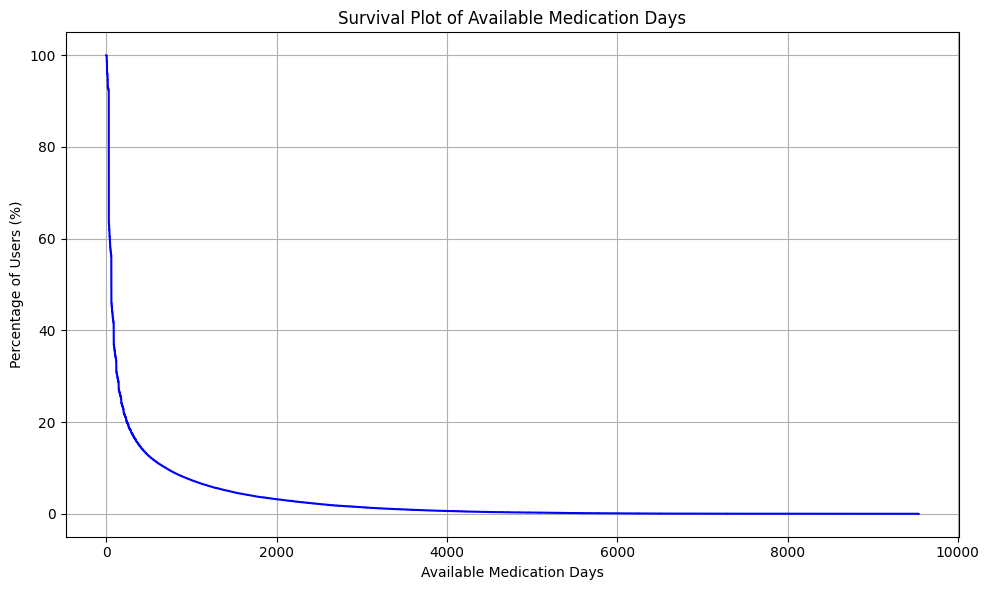

In [ ]:
# Compute survival-style cumulative distribution
survival_counts = (
    morphine_codeine["available_medication_days"]
    .value_counts()
    .sort_index(ascending=False)
    .cumsum()
)
survival_counts = survival_counts[::-1]  # Reverse for increasing x-axis
survival_percent = (survival_counts / survival_counts.max()) * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.step(survival_percent.index, survival_percent.values, where="post", color="blue")

plt.xlabel("Available Medication Days")
plt.ylabel("Percentage of Users (%)")
plt.title("Survival Plot of Available Medication Days")
plt.grid(True)
plt.tight_layout()
plt.show()

## Obtain eids and diagnosis start day per disease

In [ ]:
# Load the 'Date of first in-patient diagnosis - ICD10' table
hesin_diag = dataset["hesin_diag"]
hesin = dataset["hesin"]

# Extract all field names from the table
field_names_hesin_diag = [f.name for f in hesin_diag.fields]
field_names_hesin = [f.name for f in hesin.fields]

# Retrieve the fields
diagnosis_df = hesin_diag.retrieve_fields(
    names=field_names_hesin_diag, engine=dxdata.connect()
)
hesin_df = hesin.retrieve_fields(names=field_names_hesin, engine=dxdata.connect())

print(diagnosis_df.columns)
print(hesin_df.columns)

# Filter the HESIN_DIAG table to include only the EIDs in morphine_codeine
eid_list = morphine_codeine["eid"].unique().tolist()
filtered_diagnosis_df = diagnosis_df.filter(diagnosis_df["eid"].isin(eid_list))

print(f"Number of entries era {filtered_diagnosis_df.count()}")
filtered_diagnosis_df.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['dnx_hesin_diag_id', 'dnx_hesin_id', 'eid', 'ins_index', 'arr_index', 'level', 'diag_icd9', 'diag_icd9_nb', 'diag_icd10', 'diag_icd10_nb']
['dnx_hesin_id', 'eid', 'ins_index', 'epiorder', 'spell_index', 'spell_seq', 'spelbgin', 'spelend', 'speldur', 'pctcode', 'gpprpct', 'category', 'elecdate', 'dsource', 'elecdur', 'admidate', 'admimeth_uni', 'admimeth', 'admisorc_uni', 'admisorc', 'firstreg', 'classpat_uni', 'classpat', 'intmanag_uni', 'source', 'intmanag', 'mainspef_uni', 'mainspef', 'tretspef_uni', 'tretspef', 'operstat', 'disdate', 'dismeth_uni', 'dismeth', 'disdest_uni', 'epistart', 'disdest', 'carersi', 'epiend', 'epidur', 'bedyear', 'epistat', 'epitype']
Number of entries era 4933602
+-----------------+------------+---------+---------+-----+---------+------------+----------+-------------+
|dnx_hesin_diag_id|dnx_hesin_id|ins_index|arr_index|level|diag_icd9|diag_icd9_nb|diag_icd10|diag_icd10_nb|
+-----------------+------------+---------+---------+-----+---------+------------+---

In [ ]:
# Perform a left join to keep only rows from filtered_diagnosis_df and add epistart from hesin_df
filtered_diagnosis_df = filtered_diagnosis_df.join(
    hesin_df.select("eid", "ins_index", "epistart"),  # Selecting only necessary columns
    on=["eid", "ins_index"],
    how="left",
)

print(f"Number of entries era {filtered_diagnosis_df.count()}")
filtered_diagnosis_df.drop("eid").show(3, truncate=False)

Number of entries era 4933602
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
|ins_index|dnx_hesin_diag_id|dnx_hesin_id|arr_index|level|diag_icd9|diag_icd9_nb|diag_icd10|diag_icd10_nb|epistart  |
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
|42       |1273199-42-1     |1273199-42  |1        |2    |NULL     |NULL        |M059      |NULL         |2019-03-01|
|4        |1898529-4-2      |1898529-4   |2        |2    |NULL     |NULL        |Z901      |NULL         |2010-05-04|
|27       |1144086-27-3     |1144086-27  |3        |2    |NULL     |NULL        |I209      |NULL         |2017-11-02|
+---------+-----------------+------------+---------+-----+---------+------------+----------+-------------+----------+
only showing top 3 rows



In [ ]:
# Select only the required columns
final_diagnosis_df = filtered_diagnosis_df.select(
    "eid", "ins_index", "arr_index", "diag_icd10", "epistart"
)
# Format date columns
final_diagnosis_df = final_diagnosis_df.withColumn(
    "epistart", F.to_date(F.col("epistart"), "dd/MM/yyyy")
)

# Show the results
final_diagnosis_df.drop("eid").show(3, truncate=False)
print(f"Number of entries era {final_diagnosis_df.count()}")

+---------+---------+----------+----------+
|ins_index|arr_index|diag_icd10|epistart  |
+---------+---------+----------+----------+
|42       |1        |M059      |2019-03-01|
|4        |2        |Z901      |2010-05-04|
|27       |3        |I209      |2017-11-02|
+---------+---------+----------+----------+
only showing top 3 rows

Number of entries era 4933602


In [20]:
final_diagnosis_df = final_diagnosis_df.dropDuplicates(
    ["eid", "diag_icd10", "epistart"]
)

final_diagnosis_df.drop("eid").show(truncate=False)
print(f"Number of entries after removing duplicates: {final_diagnosis_df.count()}")

+---------+---------+----------+----------+
|ins_index|arr_index|diag_icd10|epistart  |
+---------+---------+----------+----------+
|3        |2        |Z824      |2014-10-08|
|19       |2        |I709      |2022-01-27|
|20       |7        |N19       |2019-04-18|
|47       |0        |C829      |2018-04-23|
|18       |8        |M199      |2018-09-27|
|54       |7        |I679      |2021-08-11|
|2        |1        |I10       |2019-06-16|
|29       |0        |K429      |2006-03-03|
|8        |0        |H402      |2012-01-06|
|12       |8        |F329      |2021-11-10|
|6        |18       |M4780     |2020-03-04|
|6        |1        |E780      |2016-08-02|
|8        |0        |R195      |2019-03-07|
|29       |1        |E114      |2009-09-23|
|42       |0        |N47       |2017-08-21|
|18       |4        |C788      |2011-11-04|
|60       |18       |Z926      |2022-02-12|
|15       |3        |I259      |2014-01-26|
|26       |0        |R194      |2017-06-02|
|41       |1        |Z850      |

Add a column 'time_to_F_commorbidities' calculating the number of available days of treatment (taking in account start_dates and end_dates and the overlapping) until diagnosed with first icd10 code starting with F (from epistarts), if the person is not diagnosed with any of this diseases after starting the treatment, just write a "NO"

In [ ]:
# Filter Spark dataframe by eid and diag_icd10 starting with 'F'
filtered_diseases_diagnosis_df = final_diagnosis_df.filter(
    F.col("diag_icd10").startswith("F")
)

filtered_diseases_diagnosis_pd_df = filtered_diseases_diagnosis_df.toPandas()

# Group by eid and aggregate diag_icd10 and epistart as lists
grouped_filtered_diseases_diagnosis_pd_df = (
    filtered_diseases_diagnosis_pd_df.groupby("eid")
    .agg(F_disease_codes=("diag_icd10", list), F_epistarts=("epistart", list))
    .reset_index()
)

display(grouped_filtered_diseases_diagnosis_pd_df.drop("eid", axis=1))

,F_disease_codes,F_epistarts
0,[F522],[2015-12-04]
1,"[F171, F171]","[2013-10-22, 2015-10-26]"
2,[F058],[2022-10-13]
3,[F100],[2016-11-23]
4,"[F171, F171, F171]","[2015-06-03, 2019-05-12, 2019-05-13]"
...,...,...
24084,"[F171, F171, F171, F171, F171, F171, F171, F41...","[2014-05-23, 2022-10-27, 2012-01-30, 2022-03-1..."
24085,"[F171, F329, F329]","[2010-07-28, 2020-08-04, 2013-08-07]"
24086,"[F329, F329, F329]","[2019-02-02, 2018-09-04, 2019-02-16]"
24087,"[F171, F171]","[2021-09-02, 2021-09-01]"


In [ ]:
# Merge on eid, keeping all columns from morphine_codeine
grouped_filtered_diseases_diagnosis_pd_df["eid"] = (
    grouped_filtered_diseases_diagnosis_pd_df["eid"].astype(int)
)
morphine_codeine = morphine_codeine.merge(
    grouped_filtered_diseases_diagnosis_pd_df, on="eid", how="left"
)

# Optional: display result
display(morphine_codeine.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days,F_disease_codes,F_epistarts
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8,NaN,NaN
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58,NaN,NaN
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,NaN,NaN
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175,NaN,NaN
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249,NaN,NaN
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,NaN,NaN
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145,NaN,NaN
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566,"[F419, F329, F329, F419, F419, F329, F419]","[2009-11-18, 2022-06-17, 2022-06-16, 2009-10-1..."


In [ ]:
def calculate_time_to_F_comorbidities(row):
    # Parse dates
    start_dates = pd.to_datetime(row["start_dates_parsed"])
    end_dates = pd.to_datetime(row["end_dates_parsed"])
    gap_days = row["gap_days"]

    # F_epistarts logic
    if isinstance(row["F_epistarts"], list) and len(row["F_epistarts"]) > 0:
        F_epistarts_dates = pd.to_datetime(row["F_epistarts"])
        first_start_date = start_dates.min()
        last_end_date = end_dates.max()

        # Filter F_epistarts in range
        valid_F_epistarts = [
            d for d in F_epistarts_dates if first_start_date <= d <= last_end_date
        ]
        if not valid_F_epistarts:
            return "NO"

        # Take the earliest valid epistart
        target_date = min(valid_F_epistarts)
        total_available_days = 0

        # Iterate over drug eras
        for start, end, gap in zip(start_dates, end_dates, gap_days):
            if end <= target_date:
                # Whole era before epistart
                total_available_days += max((end - start).days - gap, 0)
            elif start < target_date:
                # Era overlaps with epistart
                partial_days = max((target_date - start).days - gap, 0)
                total_available_days += partial_days
            else:
                # Era starts after epistart
                continue

        return total_available_days

    return "NO"


# Apply the function
morphine_codeine["time_to_F_comorbidities"] = morphine_codeine.apply(
    calculate_time_to_F_comorbidities, axis=1
)

# Display result
display(morphine_codeine.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days,F_disease_codes,F_epistarts,time_to_F_comorbidities
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8,NaN,NaN,NO
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58,NaN,NaN,NO
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,NaN,NaN,NO
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175,NaN,NaN,NO
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62,NaN,NaN,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249,NaN,NaN,NO
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,NaN,NaN,NO
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145,NaN,NaN,NO
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566,"[F419, F329, F329, F419, F419, F329, F419]","[2009-11-18, 2022-06-17, 2022-06-16, 2009-10-1...",200


In [24]:
count_with_f_comorbidity = (morphine_codeine["time_to_F_comorbidities"] != "NO").sum()
print("Rows with F comorbidity after treatment start:", count_with_f_comorbidity)

Rows with F comorbidity after treatment start: 6509


For the survival analysis we need to get the last prescription days and the death date to get right censored data (People that did not stop medication)

In [ ]:
# Convert the date column to proper date format
df_era_converted = df_era.withColumn(
    "drug_era_end_date_converted", F.to_date(F.col("drug_era_end_date"), "dd/MM/yyyy")
)

# Get the latest date
end_prescriptions_date_row = df_era_converted.agg(
    F.max("drug_era_end_date_converted").alias("end_prescriptions_date")
).collect()[0]

# Extract the date value into a variable
end_prescriptions_date = end_prescriptions_date_row["end_prescriptions_date"]

print(f"Last drug era end date: {end_prescriptions_date}")

Last drug era end date: 2019-09-14


In [ ]:
# Load table
omop_death = dataset["omop_death"]

# Extract all field names from the table
field_names = [f.name for f in omop_death.fields]

# Retrieve the fields
death_df = omop_death.retrieve_fields(names=field_names, engine=dxdata.connect())

# Keep only the columns you need and convert death_date to date format
death_df = (
    death_df.select(
        "eid", F.to_date("death_date", "dd/MM/yyyy").alias("death_date")
    ).dropDuplicates(["eid"])  # Remove duplicate EIDs if they exist
)

print(death_df.columns)
death_df.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'death_date']
+----------+
|death_date|
+----------+
|2009-11-25|
|2012-11-11|
|2010-08-03|
+----------+
only showing top 3 rows



In [27]:
death_pd_df = death_df.toPandas()
death_pd_df["eid"] = death_pd_df["eid"].astype(int)
# Add the date of death to our data frame
morphine_codeine = morphine_codeine.merge(death_pd_df, on="eid", how="left")
display(morphine_codeine.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days,F_disease_codes,F_epistarts,time_to_F_comorbidities,death_date
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8,NaN,NaN,NO,NaN
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58,NaN,NaN,NO,NaN
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,NaN,NaN,NO,NaN
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175,NaN,NaN,NO,NaN
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62,NaN,NaN,NO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249,NaN,NaN,NO,NaN
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,NaN,NaN,NO,NaN
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145,NaN,NaN,NO,NaN
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566,"[F419, F329, F329, F419, F419, F329, F419]","[2009-11-18, 2022-06-17, 2022-06-16, 2009-10-1...",200,NaN


In [ ]:
# Make sure end_prescriptions_date is a datetime
end_prescriptions_date = pd.to_datetime("2019-09-14")

# Ensure death_date is datetime
morphine_codeine["death_date"] = pd.to_datetime(morphine_codeine["death_date"])

# Get last drug era end date per row (from end_dates_parsed)
morphine_codeine["last_drug_end_date"] = morphine_codeine["end_dates_parsed"].apply(
    lambda x: max(x)
)

# Determine right censoring
morphine_codeine["right_censored"] = morphine_codeine.apply(
    lambda row: int(
        row["last_drug_end_date"]
        >= (
            row["death_date"]
            if pd.notnull(row["death_date"])
            else end_prescriptions_date
        )
    ),
    axis=1,
)
display(morphine_codeine.drop("eid", axis=1))

,drugs,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days,F_disease_codes,F_epistarts,time_to_F_comorbidities,death_date,last_drug_end_date,right_censored
0,[codeine],1,[2004-12-20],[2004-12-28],[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8,NaN,NaN,NO,NaT,2004-12-28,0
1,"[codeine, codeine]",2,"[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58,NaN,NaN,NO,NaT,2013-04-20,0
2,"[codeine, codeine, codeine]",3,"[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,NaN,NaN,NO,NaT,2013-07-05,0
3,"[codeine, codeine, codeine, codeine, codeine, ...",6,"[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175,NaN,NaN,NO,NaT,2009-10-20,0
4,"[codeine, codeine, codeine]",3,"[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62,NaN,NaN,NO,NaT,2014-12-16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103444,"[codeine, codeine, codeine, codeine, codeine, ...",7,"[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249,NaN,NaN,NO,NaT,2011-09-09,0
103445,"[codeine, codeine, codeine, codeine, codeine, ...",10,"[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,NaN,NaN,NO,NaT,2015-03-07,0
103446,"[codeine, codeine, codeine, codeine, codeine]",5,"[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145,NaN,NaN,NO,NaT,2016-05-26,0
103447,"[codeine, codeine, codeine, codeine, codeine, ...",8,"[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566,"[F419, F329, F329, F419, F419, F329, F419]","[2009-11-18, 2022-06-17, 2022-06-16, 2009-10-1...",200,NaT,2016-05-28,0


In [29]:
num_unique_eids = morphine_codeine["eid"].nunique()
print("Number of unique eids:", num_unique_eids)
num_right_censored = morphine_codeine["right_censored"].sum()
print(f"Number of right-censored individuals: {num_right_censored}")
count_with_f_comorbidity = (morphine_codeine["time_to_F_comorbidities"] != "NO").sum()
print("Rows with F comorbidity after treatment start:", count_with_f_comorbidity)

Number of unique eids: 103449
Number of right-censored individuals: 1515
Rows with F comorbidity after treatment start: 6509


### Keeping target diseases
Now from all these users we want to keep the ones with certain target diseases (Run Target_diseases.ipynb to obtain the list of eids). In this case we are keeping users that have been diagnosed with disease codes starting with M, keeping only the diseases diagnosed to > 1000 users.

In [30]:
!dx download "500k WGS:/WGS_Lucia/Data/phenotypes/unique_eids_target_diseases_M_1000_eids.txt"

[===========================================================>] Completed 98,544 of 98,544 bytes (100%) /opt/notebooks/unique_eids_target_diseases_M_1000_eids.txtt


In [ ]:
# Keep target diseases
unique_eids_target_diseases_M_1000_eids = np.loadtxt(
    "unique_eids_target_diseases_M_1000_eids.txt", dtype=int
)
# Filter the DataFrame
morphine_codeine_target_diseases = morphine_codeine[
    morphine_codeine["eid"].astype(int).isin(unique_eids_target_diseases_M_1000_eids)
]
num_unique_eids = morphine_codeine_target_diseases["eid"].nunique()
print("Number of unique eids:", num_unique_eids)
num_right_censored = morphine_codeine_target_diseases["right_censored"].sum()
print(f"Number of right-censored individuals: {num_right_censored}")
count_with_f_comorbidity = (
    morphine_codeine_target_diseases["time_to_F_comorbidities"] != "NO"
).sum()
print("Rows with F comorbidity after treatment start:", count_with_f_comorbidity)

Number of unique eids: 12318
Number of right-censored individuals: 325
Rows with F comorbidity after treatment start: 2329


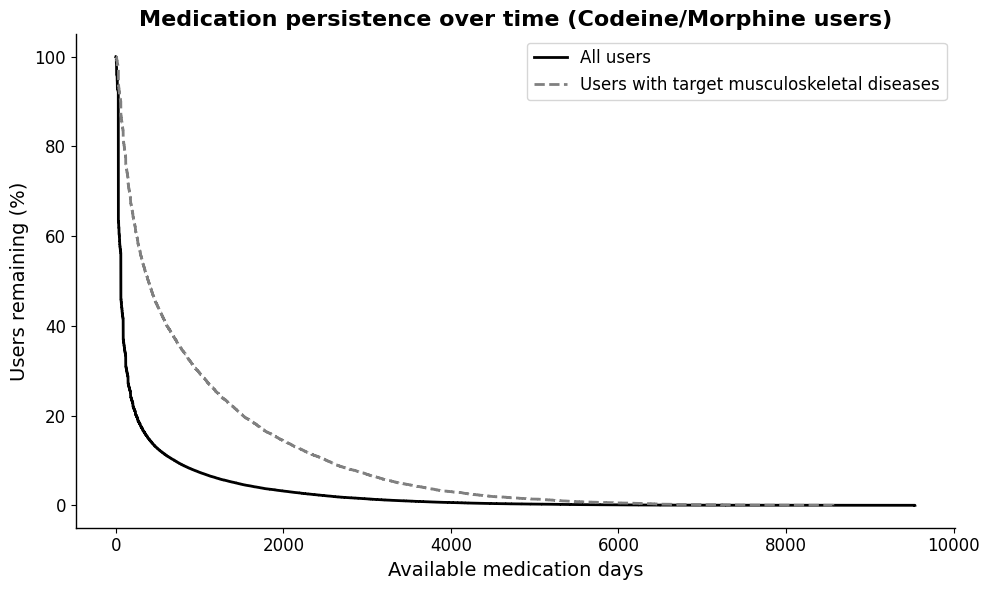

In [ ]:
# Compute survival-style cumulative distribution for morphine_codeine
survival_counts_1 = (
    morphine_codeine["available_medication_days"]
    .value_counts()
    .sort_index(ascending=False)
    .cumsum()
)
survival_counts_1 = survival_counts_1[::-1]  # Reverse for increasing x-axis
survival_percent_1 = (survival_counts_1 / survival_counts_1.max()) * 100

# Compute survival-style cumulative distribution for morphine_codeine_target_diseases
survival_counts_2 = (
    morphine_codeine_target_diseases["available_medication_days"]
    .value_counts()
    .sort_index(ascending=False)
    .cumsum()
)
survival_counts_2 = survival_counts_2[::-1]  # Reverse for increasing x-axis
survival_percent_2 = (survival_counts_2 / survival_counts_2.max()) * 100

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.step(
    survival_percent_1.index,
    survival_percent_1.values,
    where="post",
    color="black",
    linewidth=2,
    label="All users",
)
ax.step(
    survival_percent_2.index,
    survival_percent_2.values,
    where="post",
    color="grey",
    linestyle="--",
    linewidth=2,
    label="Users with target musculoskeletal diseases",
)

# Title and axis labels
ax.set_title(
    "Medication persistence over time (Codeine/Morphine users)",
    fontsize=16,
    fontweight="bold",
)
ax.set_xlabel("Available medication days", fontsize=14)
ax.set_ylabel("Users remaining (%)", fontsize=14)

# Hide top and right spines (the box)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Keep bottom and left axes
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Remove grid
ax.grid(False)

# Adjust ticks
ax.tick_params(axis="both", labelsize=12)

# Legend
ax.legend(fontsize=12)

# Layout and save
plt.tight_layout()

# Save plot
plt.savefig("survival_plot_medication_days.png", dpi=300, bbox_inches="tight")

plt.show()

### DataFrame formating
Now run this for each file: all users (morphine_codeine) and target diseases users(morphine_codeine_target_diseases)

In [37]:
participant = dataset["participant"]
df_participant = participant.retrieve_fields(names=["eid"], engine=dxdata.connect())
# Convert the Spark DataFrame 'participant' to a Pandas DataFrame
participant_df = df_participant.select("eid").toPandas()

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


In [ ]:
# 1. Create phenotype columns initialized to None
participant_df["Available_medication_days"] = None
participant_df["Treatment_end"] = None
participant_df["Available_medication_days_to_F_comorbidity"] = None
participant_df["F_comorbidity_event"] = None

participant_df["eid"] = participant_df["eid"].astype(int)

# Merge relevant data onto participant_df
merged_df = participant_df.merge(
    morphine_codeine[
        [
            "eid",
            "available_medication_days",
            "time_to_F_comorbidities",
            "right_censored",
        ]
    ],
    on="eid",
    how="left",
)


def process_row(row):
    # If either value is NaN, set all outputs to NaN
    if pd.isna(row["available_medication_days"]) or pd.isna(
        row["time_to_F_comorbidities"]
    ):
        row["Available_medication_days"] = np.nan
        row["Treatment_end"] = np.nan
        row["Available_medication_days_to_F_comorbidity"] = np.nan
        row["F_comorbidity_event"] = np.nan
        return row

    # Treatment_end: 0 if right censored, else 1
    row["Available_medication_days"] = row["available_medication_days"]
    row["Treatment_end"] = 0 if row["right_censored"] == 1 else 1

    # F_comorbidity_event: 1 if event occurred (i.e., not "NO"), else 0
    if row["time_to_F_comorbidities"] == "NO":
        row["Available_medication_days_to_F_comorbidity"] = row[
            "available_medication_days"
        ]
        row["F_comorbidity_event"] = 0
    else:
        row["Available_medication_days_to_F_comorbidity"] = row[
            "time_to_F_comorbidities"
        ]
        row["F_comorbidity_event"] = 1

    return row


# Apply to your DataFrame
merged_df = merged_df.apply(process_row, axis=1)

# Drop helper columns if needed
participant_df = merged_df.drop(
    columns=["available_medication_days", "time_to_F_comorbidities", "right_censored"]
)

In [39]:
display(participant_df.drop("eid", axis=1))

,Available_medication_days,Treatment_end,Available_medication_days_to_F_comorbidity,F_comorbidity_event
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,29.0,1.0,29.0,0.0
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
502231,NaN,NaN,NaN,NaN
502232,29.0,1.0,29.0,0.0
502233,NaN,NaN,NaN,NaN
502234,NaN,NaN,NaN,NaN


In [40]:
clean_df = participant_df.dropna()
display(clean_df.drop("eid", axis=1))

,Available_medication_days,Treatment_end,Available_medication_days_to_F_comorbidity,F_comorbidity_event
2,29.0,1.0,29.0,0.0
7,130.0,1.0,130.0,0.0
12,305.0,1.0,305.0,0.0
17,116.0,1.0,116.0,0.0
18,297.0,0.0,297.0,0.0
...,...,...,...,...
502220,29.0,1.0,29.0,0.0
502222,58.0,1.0,58.0,0.0
502227,58.0,1.0,58.0,0.0
502232,29.0,1.0,29.0,0.0


In [ ]:
# Count number of 1's in each phenotype column
phenotype_counts = participant_df[["Treatment_end", "F_comorbidity_event"]].sum()

print(phenotype_counts)

Treatment_end          101934.0
F_comorbidity_event      6509.0
dtype: float64


In [ ]:
# Set the 'eid' column as the index
participant_df.set_index("eid", inplace=True)

# Insert 'FID' and 'IID' as the first two columns using the index
participant_df.insert(0, "FID", participant_df.index)
participant_df.insert(1, "IID", participant_df.index)

In [ ]:
# Save the result as a TSV file
participant_df.to_csv(
    "phenotypes_all_users_survival_analysis.tsv", sep="\t", index=False, na_rep="NA"
)

In [44]:
! dx upload phenotypes_all_users_survival_analysis.tsv --path /WGS_Lucia/Data/phenotypes/

[===========================================================>] Uploaded 14,761,112 of 14,761,112 bytes (100%) phenotypes_all_users_survival_analysis.tsv
ID                                file-J08FB8jJb4JBVJjVxbBYvXk8
Class                             file
Project                           project-GfVK998Jb4JJgVBjKXPyxJ9q
Folder                            /WGS_Lucia/Data/phenotypes
Name                              phenotypes_all_users_survival_analysis.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Apr 29 11:16:51 2025
Created by                        luciass6
 via the job                      job-J08BYYQJb4J8KgKJXjYvK203
Last modified                     Tue Apr 29 11:16:52 2025
Media type                        
archivalState                     "live"
cloudAccoun

## Count the eids per mask 

In [45]:
!dx download "500k WGS:/WGS_Lucia/WGS_QC/Output/mask_morphine_eid_df.tsv"

[===========================================================>] Completed 1,461,100 of 1,461,100 bytes (100%) /opt/notebooks/mask_morphine_eid_df.tsvv


In [ ]:
# Step 1: Read the mask EID table
mask_eid_df = pd.read_csv("mask_morphine_eid_df.tsv", sep="\t")

# IMPORTANT: Convert the string list to a real list
mask_eid_df["EIDs"] = mask_eid_df["EIDs"].apply(ast.literal_eval)


# Step 2: Prepare phenotype EID sets
phenotype_columns = ["Treatment_end", "F_comorbidity_event"]

participant_df["FID"] = participant_df["FID"].astype(str)
phenotype_eids = {
    "Treatment_end_1": set(
        participant_df[participant_df["Treatment_end"] == 1]["FID"].tolist()
    ),
    "Treatment_end_0": set(
        participant_df[participant_df["Treatment_end"] == 0]["FID"].tolist()
    ),
    "F_comorbidity_event_1": set(
        participant_df[participant_df["F_comorbidity_event"] == 1]["FID"].tolist()
    ),
    "F_comorbidity_event_0": set(
        participant_df[participant_df["F_comorbidity_event"] == 0]["FID"].tolist()
    ),
}

# Step 3: Create result table
result_rows = []

for _, row in mask_eid_df.iterrows():
    mask = row["Mask"]
    mask_eids = set(row["EIDs"])  # Set for fast lookup

    for pheno_name, pheno_eids in phenotype_eids.items():
        overlap = mask_eids.intersection(pheno_eids)
        result_rows.append(
            {
                "Mask": mask,
                "Phenotype_Event": pheno_name,
                "Overlap_EID_Count": len(overlap),
            }
        )

# Step 4: Create final DataFrame
mask_phenotype_overlap_df = pd.DataFrame(result_rows)

# Calculate total counts for each phenotype
total_counts = []
for pheno_name, pheno_eids in phenotype_eids.items():
    total_counts.append(
        {
            "Mask": "Total",  # Special label for totals
            "Phenotype_Event": pheno_name,
            "Overlap_EID_Count": len(pheno_eids),
        }
    )

# Add these totals to the final DataFrame
mask_phenotype_overlap_df = pd.concat(
    [mask_phenotype_overlap_df, pd.DataFrame(total_counts)], ignore_index=True
)

# Preview
display(mask_phenotype_overlap_df)

,Mask,Phenotype_Event,Overlap_EID_Count
0,No_efficacy,Treatment_end_1,429
1,No_efficacy,Treatment_end_0,5
2,No_efficacy,F_comorbidity_event_1,26
3,No_efficacy,F_comorbidity_event_0,408
4,WT_efficacy,Treatment_end_1,2619
5,WT_efficacy,Treatment_end_0,25
6,WT_efficacy,F_comorbidity_event_1,183
7,WT_efficacy,F_comorbidity_event_0,2461
8,No_efficacy_High_Impact_Variants,Treatment_end_1,536
9,No_efficacy_High_Impact_Variants,Treatment_end_0,6


In [ ]:
mask_phenotype_overlap_df.to_csv(
    "mask_phenotype_all_users_survival_overlap.tsv", sep="\t", index=False
)

In [49]:
# Upload DataFrame
!dx upload mask_phenotype_all_users_survival_overlap.tsv --path WGS_Lucia/Data/Output_regenie/survival/morphine_codeine/all_users/burden_test/

[===========================================================>] Uploaded 926 of 926 bytes (100%) mask_phenotype_all_users_survival_overlap.tsv
ID                                file-J08FBj0Jb4JBVJjVxbBYvXz4
Class                             file
Project                           project-GfVK998Jb4JJgVBjKXPyxJ9q
Folder                            /WGS_Lucia/Data/Output_regenie/survival/morphine_codeine/all_users
                                  /burden_test
Name                              mask_phenotype_all_users_survival_overlap.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Apr 29 11:17:52 2025
Created by                        luciass6
 via the job                      job-J08BYYQJb4J8KgKJXjYvK203
Last modified                     Tue Apr 29 11:17:53 2025
Media ty